In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from utils import load_hidden_representations_from_hdf5, read_templates_from_file

----

In [14]:
# params
log_dir = "data"
model = "bigscience-T0_3B" # bigscience-T0_B or bigscience-T0
module = "decoder" # encoder or decoder
task = "rte"

## Prompts

In [3]:
df = read_templates_from_file(f"prompts/{task}.csv")
display(df)

,name,template,category,shuffle
0,null_pattern,{premise} {hypothesis},neutral,False
1,null_pattern_reversed,{hypothesis} {premise},neutral,False
2,gpt_3_yes_no,{premise} Question: {hypothesis} Yes or No?,instructive,False
3,gpt_3_yes_no_shuffled,{premise} Question: {hypothesis} Yes or No?,instructive,True
4,gpt_3_true_false,{premise} Question: {hypothesis} True or False?,instructive,False
5,gpt_3_true_false_shuffled,{premise} Question: {hypothesis} True or False?,instructive,True
6,start_with_the,"{premise} Does the paragraph start with ""the""?...",misleading,False
7,mnli_crowdsource,{premise} Using only the above description and...,instructive,False
8,based_on_previous_passage,{premise} Based on the previous passage; is it...,instructive,False
9,infer,"Suppose {premise} Can we infer that ""{hypothes...",instructive,False


## Plot t-SNE embeddings

In [4]:
# specify which patterns to use for classification
use_pattern = [
    # "null_pattern",
    # "null_pattern_reversed",
    "gpt_3_yes_no",
    # "gpt_3_yes_no_shuffled",
    "gpt_3_true_false",
    # "gpt_3_true_false_shuffled",
    # "start_with_the",
    "mnli_crowdsource",
    "based_on_previous_passage",
    "infer",
    "follow",
    "imply",
    "guaranteed",
    "justified", 
    "must_be_true",
    "should_assume"
]

In [49]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from collections import Counter

for layer in [24]:
    file_names, prompt_names = [], []

    for _, row in df.iterrows():
        if row['name'] in use_pattern:
            file_names.append(f"{model}/{module}/{row['name']}/hidden_represenations_layer{layer}_avg.hdf5",)
            prompt_names.append(row['name'])
    
    # load hidden representations from hdf5 file
    representations = None
    n_sequences = 0

    data = [
        load_hidden_representations_from_hdf5(os.path.join(log_dir, file_name))
        for file_name in file_names
    ]
    data_flat = np.concatenate(data)
    # data_flat = StandardScaler().fit_transform(data_flat)

    cluster_count = len(file_names)
    sample_count = len(data[0])

    cluster_model = KMeans(n_clusters=cluster_count)
    cluster_model.fit(data_flat)
    pred = cluster_model.predict(data_flat)

    pred = [
        pred[prompt_i*sample_count:(prompt_i+1)*sample_count]
        for prompt_i in range(cluster_count)
    ]
    
    homogenity = [
        np.average(cluster == Counter(cluster).most_common(1)[0][0])
        for cluster in pred
    ]
    print(f'Average homogenity: {np.average(homogenity):.2%}')

Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 7120.58it/s]


Average homogenity: 23.79%


Reading embeddings: 100%|██████████| 277/277 [00:00<00:00, 6780.88it/s]


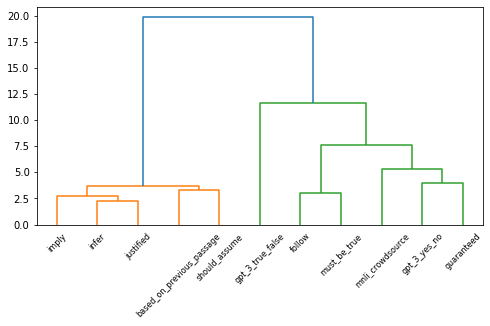

In [54]:
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from collections import Counter

for layer in [24]:
    file_names, prompt_names = [], []

    for _, row in df.iterrows():
        if row['name'] in use_pattern:
            file_names.append(f"{model}/{module}/{row['name']}/hidden_represenations_layer{layer}_avg.hdf5",)
            prompt_names.append(row['name'])
    
    # load hidden representations from hdf5 file
    representations = None
    n_sequences = 0

    data = [
        np.average(load_hidden_representations_from_hdf5(os.path.join(log_dir, file_name)), axis=0)
        for file_name in file_names
    ]
    Z = linkage(data, 'ward')
    plt.figure(figsize=(8, 4))
    dendrogram(Z, leaf_rotation=45, leaf_font_size=8, labels=prompt_names)
